In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, multivariate_normal

from cosmoprimo import *

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *
from densitysplit.utils import *

plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

# To activate logging
setup_logging()

In [2]:
#plt.rcParams["figure.figsize"] = (10, 4)
#plt.rcParams['figure.dpi'] = 200

## Global parameters

In [11]:
# Mock parameters
cosmology=fiducial.AbacusSummitBase()
z = 1.175
bias = 1.8

# Mocks
nmocks = 5000

# Density smoothing parameters
cellsize = 10
resampler = 'tsc'

In [27]:
# DS correlation functions parameters
ells = [0]
nells = len(ells)
randoms_size = 4
nsplits = 3

## Abacus mock to compare to model

In [12]:
data_dir = '/feynman/work/dphp/mp270220/'
catalog_name = 'data/AbacusSummit_2Gpc_z1.175'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
nbar = catalog.size/catalog.boxsize**3

ccf_name = 'outputs/correlation_functions/AbacusSummit_2Gpc_z1.175_densitySplit_rh_CCFs_cellsize10_randomsize4.npy'

In [55]:
nbar

0.00293291175

In [39]:
catalog_density = density_split.DensitySplit(catalog)
catalog_density.compute_density(cellsize=cellsize, resampler=resampler, use_rsd=False, use_weights=False)

[002032.98]  01-26 11:57  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 23463294.
[002034.57]  01-26 11:57  CatalogMesh                  INFO     Painted 4194304 out of 23463294 objects to mesh.
[002034.57]  01-26 11:57  CatalogMesh                  INFO     Slab 4194304 ~ 8388608 / 23463294.
[002035.77]  01-26 11:57  CatalogMesh                  INFO     Painted 8388608 out of 23463294 objects to mesh.
[002035.77]  01-26 11:57  CatalogMesh                  INFO     Slab 8388608 ~ 12582912 / 23463294.
[002036.81]  01-26 11:57  CatalogMesh                  INFO     Painted 12582912 out of 23463294 objects to mesh.
[002036.82]  01-26 11:57  CatalogMesh                  INFO     Slab 12582912 ~ 16777216 / 23463294.
[002037.86]  01-26 11:57  CatalogMesh                  INFO     Painted 16777216 out of 23463294 objects to mesh.
[002037.86]  01-26 11:57  CatalogMesh                  INFO     Slab 16777216 ~ 20971520 / 23463294.
[002038.91]  01-26 11:57  CatalogMesh               

In [82]:
densities = catalog_density.data_densities

In [83]:
sigma_RR = np.std(densities)
sigma_RR

0.6655606457713437

## Compute $\xi_R$

In [37]:
def compute_xi_R(data_density, edges, seed=0, los=None, use_rsd=False, use_weights=False, nthreads=128):
    data = data_density.data

    if use_rsd and data.positions_rsd is not None:
        positions2 = data.positions_rsd
    else:
        positions2 = data.positions

    if use_weights and (data.weights is not None):
        weights2 = data.weights
    else:
        weights2 = None

    ## Generate random particles and readout density at each particle
    rng = np.random.RandomState(seed=seed)
    positions1 = [o + rng.uniform(0., 1., data_density.data.size)*b for o, b in zip((data_density.offset,)*3, (data_density.boxsize,)*3)]
    shifted_positions1 = np.array(positions1) - data_density.offset
    densities = data_density.density_mesh.readout(shifted_positions1.T, resampler=data_density.resampler)

    weights1 = 1 + densities

    result = TwoPointCorrelationFunction('smu', edges,
                                        data_positions1=positions1, data_positions2=positions2,
                                        data_weights1=weights1, data_weights2=weights2,
                                        boxsize=data_density.boxsize,
                                        engine='corrfunc', nthreads=nthreads,
                                        los = los)

    return result

In [40]:
abacus_xi_R = compute_xi_R(catalog_density, edges=(np.linspace(0., 150., 151), np.linspace(-1, 1, 201)), seed=0, los='x', use_rsd=False, use_weights=False, nthreads=128)

[002056.13]  01-26 11:57  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[002056.13]  01-26 11:57  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[002687.06]  01-26 12:07  TwoPointCorrelationFunction  INFO     Analytically computing two-point counts R1R2.


In [42]:
abacus_xi_R

In [50]:
test = abacus_xi_R.get_corr(ells=ells, return_sep=False) 
test.shape

(1, 150)

## Initialize Gaussian model

In [14]:
model = SplitCCFModel(redshift=z, cosmology=cosmology, bias=bias, nbar=nbar)

/feynman/work/dphp/adematti/cosmodesiconda/20220713-1.0.0/code/cosmoprimo/main/lib/python3.9/site-packages/cosmoprimo/interpolator.py:517: ComplexWarning: Casting complex values to real discards the imaginary part
  k = np.asarray(k, dtype=dtype)


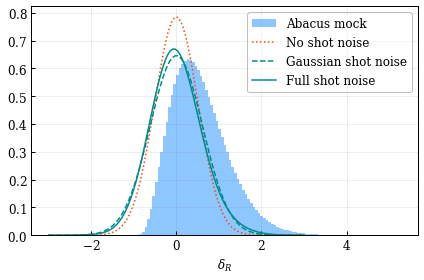

In [87]:
delta = np.linspace(-3, 3, 100)

model_density_no_shot_noise = scipy.stats.norm.pdf(delta, 0, model.sigma_RR)
model_density_gaussian_shot_noise = model.density_with_shot_noise(delta, p=2)
model_density_full_shot_noise = model.density_with_shot_noise(delta, p=4)

plt.hist(np.ravel(catalog_density.data_densities), bins=100, density=True, alpha=0.5, label='Abacus mock')
plt.plot(delta, model_density_no_shot_noise, label='No shot noise', ls=':', color='orangered')
plt.plot(delta, model_density_gaussian_shot_noise, label='Gaussian shot noise', ls='--', color='darkcyan')
plt.plot(delta, model_density_full_shot_noise, label='Full shot noise', ls='-', color='darkcyan')
plt.xlabel(r'$\delta_R$')
    
plt.legend()
plt.savefig('gaussianModelvsAbacusMock_delta_R.pdf', dpi=200)
plt.show()

In [16]:
abacus_ccf_rh = np.load(data_dir+ccf_name, allow_pickle=True)
abacus_xiell_rh = [res.get_corr(ells=ells, return_sep=False) for res in abacus_ccf_rh]

In [25]:
s, _, res = abacus_ccf_rh[0].get_corr(return_sep=True)

In [74]:
from pandas import qcut
test, th_bins = qcut(densities, nsplits, retbins=True)

In [75]:
th_bins

array([-0.97569477, -0.06067808,  0.44654997,  7.19130353])

In [76]:
#th_bins = scipy.stats.norm.ppf(q=[0, 1./3, 2./3, 1], loc=0, scale=model.sigma_RR)

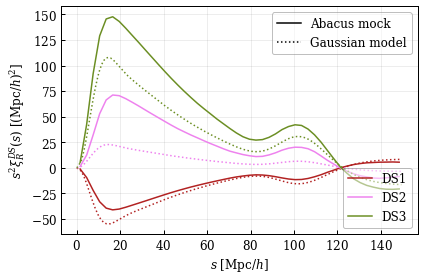

In [77]:
## Model
ccf_RH = model.ccf_randoms_tracers(density_bins=th_bins, shot_noise=True, p=4)

colors = ['firebrick', 'violet', 'olivedrab']

for ill, ell in enumerate(ells):
    for ds in range(nsplits):
        y = s**2 * abacus_xiell_rh[ds][ill]

        plt.plot(s, y, color=colors[ds])
        plt.plot(model.sep, model.sep**2 * ccf_RH[ds], ls=':', color=colors[ds])
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

lines = list()
for ds in range(nsplits):
    line, = plt.plot([], [], label=r'DS{}'.format(ds+1), color=colors[ds])
    lines.append(line)
line2, = plt.plot([], [], ls='-', color='black', label='Abacus mock')
line3, = plt.plot([], [], ls=':', color='black', label='Gaussian model')

first_legend = plt.legend(handles=lines, loc='lower right')
ax = plt.gca().add_artist(first_legend)
plt.legend(handles=[line2, line3], loc='upper right')

plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

-0.3147718849077623
0.17730577554270824
1.0378293805382084


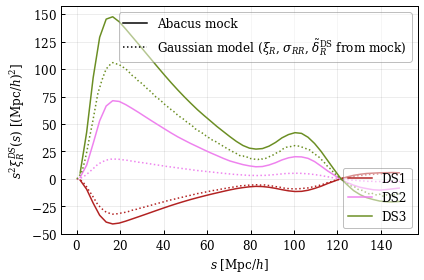

In [78]:
## Model
ccf_RH = model.ccf_randoms_tracers(density_bins=th_bins, shot_noise=True, p=4)

colors = ['firebrick', 'violet', 'olivedrab']

for ill, ell in enumerate(ells):
    for ds in range(nsplits):
        # Mock
        y = s**2 * abacus_xiell_rh[ds][ill]
        
        # Adapt model to mock
        d1 = th_bins[ds]
        d2 = th_bins[ds+1]
        
        split = np.logical_and((densities > d1), (densities <= d2))
        split_densities = densities[split]
        delta_tilde = np.mean(split_densities)
        print(delta_tilde)
        split_model = abacus_xi_R.get_corr(ells=ells, return_sep=False).T * delta_tilde / sigma_RR**2

        plt.plot(s, y, color=colors[ds])
        plt.plot(model.sep, model.sep**2 * split_model, ls=':', color=colors[ds])
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

lines = list()
for ds in range(nsplits):
    line, = plt.plot([], [], label=r'DS{}'.format(ds+1), color=colors[ds])
    lines.append(line)
line2, = plt.plot([], [], ls='-', color='black', label=r'Abacus mock')
line3, = plt.plot([], [], ls=':', color='black', label=r'Gaussian model ($\xi_R$, $\sigma_{RR}$, $\tilde{\delta}_{R}^{\mathrm{DS}}$ from mock)')

first_legend = plt.legend(handles=lines, loc='lower right')
ax = plt.gca().add_artist(first_legend)
plt.legend(handles=[line2, line3], loc='upper right')

plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.savefig('gaussianModelvsAbacusMock_densitysplits_rh.pdf', dpi=200)
plt.show()